In [1]:
%matplotlib inline
# ---- settings ----
import json
import matplotlib.pyplot as plt
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
from mpl_toolkits.mplot3d import Axes3D
sys.path.insert(0,'../')
sys.path.append('./../../easy_multi_person_pose_estimation')
from mvpose import pose
from poseestimation import model
pe = model.PoseEstimator()
import mvpose.data.transform as tfm

Settings = json.load(open('../settings.txt'))

root = join(Settings['data_root'], 'pak')

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']


X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


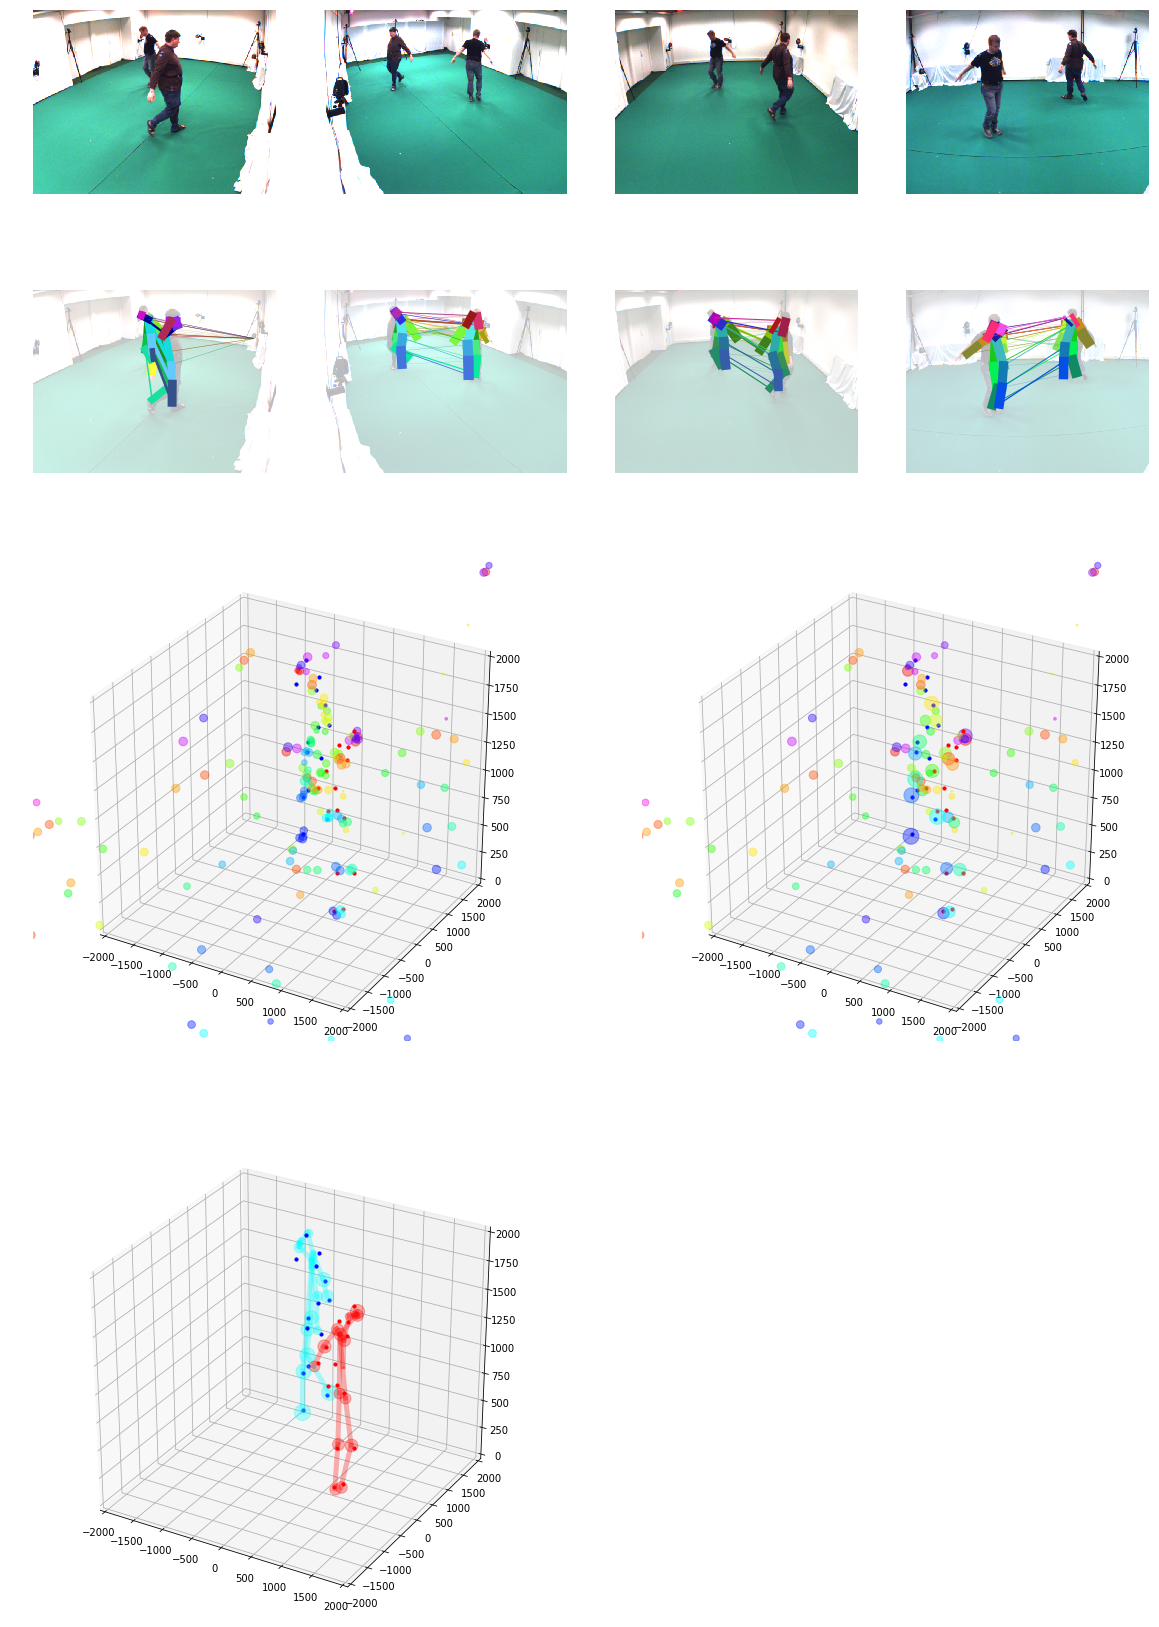

In [30]:
from mvpose.pose import estimate
from cselect import color as cs
from mvpose.plot.skeleton import generate3d
import mvpose.plot.limbs as pltlimbs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ

n = 30
FRAME = n * 25
fname = 'vid/frame%04d.png' % (n,)


Im = np.array([X[0][FRAME], 
               X[1][FRAME], 
               X[2][FRAME], 
               X[3][FRAME]])

with_gpu = False

_start = time()
if with_gpu:
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                print('...')
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)

humans, candidates = estimate(Calib, heatmaps, pafs,
                 threshold_nbr_multiview_modes=1, 
                 threshold_drop_person=7,
                 debug_info=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# PLOT
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_gt(ax):
    color = ['red', 'blue']
    for x,y,z,pid in Y[FRAME]:
        ax.scatter([x],[y],[z], color=color[int(pid)], alpha=1, s=10)


peaks2d = candidates.peaks2d
limbs2d = candidates.limbs2d

fig = plt.figure(figsize=(20, 30))

for cid in range(4):
    ax = fig.add_subplot(6,4,1+cid)
    ax.imshow(Im[cid]); ax.axis('off')
    
    ax = fig.add_subplot(6,4,5+cid)
    pltlimbs.plot(ax, Im[cid], peaks2d[cid], limbs2d[cid])
    ax.axis('off')


ax = fig.add_subplot(3,2,3, projection='3d')
ax.set_zlim([0, 2000])
ax.set_xlim([-2000, 2000])
ax.set_ylim([-2000, 2000])
plot_gt(ax)
points3d = candidates.points3d
COLORS = cs.lincolor(len(points3d) + 3)/255
for k, P in enumerate(points3d):
    ax.scatter(P[:,0],P[:,1],P[:,2], color=COLORS[k], 
               s=P[:,3]*100, alpha=0.4)


ax = fig.add_subplot(3,2,4, projection='3d')
ax.set_zlim([0, 2000])
ax.set_xlim([-2000, 2000])
ax.set_ylim([-2000, 2000])
plot_gt(ax)
modes3d = candidates.modes3d
COLORS = cs.lincolor(len(modes3d) + 3)/255
for k, P in enumerate(modes3d):
    P = P[0]
    if len(P) > 0:
        ax.scatter(P[:,0],P[:,1],P[:,2], color=COLORS[k], 
                   s=P[:,3]*100, alpha=0.4)
    

humans = candidates.humans
COLORS = cs.lincolor(len(humans.keys()) + 1)/255
    
ax = fig.add_subplot(3,2,5, projection='3d')
ax.set_zlim([0, 2000])
ax.set_xlim([-2000, 2000])
ax.set_ylim([-2000, 2000])
for idx, (key, human) in enumerate(humans.items()):
    for p in human['joints']:
        if p is not None:
            x,y,z,w = p
            ax.scatter(x,y,z, color=COLORS[idx], s=w*100, alpha=0.3)

    generate3d(ax, human['joints'], DEFAULT_LIMB_SEQ, COLORS[idx], alpha=0.3)
plot_gt(ax)


plt.savefig(fname, format='png')
    
#plt.show()